In [21]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscal
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
import gsw
import itertools
import scipy

# Exercise 1

In [22]:
# Read levitus files (only works, when in same folder as this notebook)
levitus_file = "levitus_annual.nc"
levitus = xr.open_dataset(levitus_file, engine="netcdf4")
levitus = levitus.drop_vars(["Z_01", "Z_02"])
levitus = levitus.rename(dict(X="lon", Y="lat", Z="depth", Z_01="depth",Z_02="depth")) # Rename the dimensions for easier understanding

levitus["lon"] = levitus["lon"].assign_attrs(dict(long_name="Longitude"))
levitus["lat"] = levitus["lat"].assign_attrs(dict(long_name="Latitude"))
levitus["depth"] = levitus["depth"].assign_attrs(dict(units="m", long_name="Depth"))

In [23]:
# Absolute Salinity
levitus["pressure"] = gsw.p_from_z(z=-levitus.depth, lat=levitus.lat).assign_attrs(dict(units="dbar"))
levitus["pressure"] = levitus["pressure"].assign_attrs(dict(units="dbar", long_name="Pressure"))

levitus["abs_sal"] = gsw.SA_from_SP(SP=levitus.sal, p=levitus.pressure, lon=levitus.lon, lat=levitus.lat)
levitus["abs_sal"] = levitus["abs_sal"].assign_attrs(dict(units="g/kg", long_name="Absolute Salinity"))


In [24]:
# Potential Temperature
levitus["pot_temp"] = gsw.pt0_from_t(SA=levitus.abs_sal, t=levitus.temp, p=levitus.pressure)#.assign_attrs(dict(units="degC", long_name="Potential Temperature"))
levitus["pot_temp"] = levitus["pot_temp"].assign_attrs(dict(units="degC", long_name="Potential Temperature"))

In [25]:
# Conservative Temperature
levitus["con_temp"] = (
        gsw.conversions
        .CT_from_pt(levitus.abs_sal, levitus.pot_temp)
        .assign_attrs(dict(units="degC", long_name="Conservative Temperature"))
)

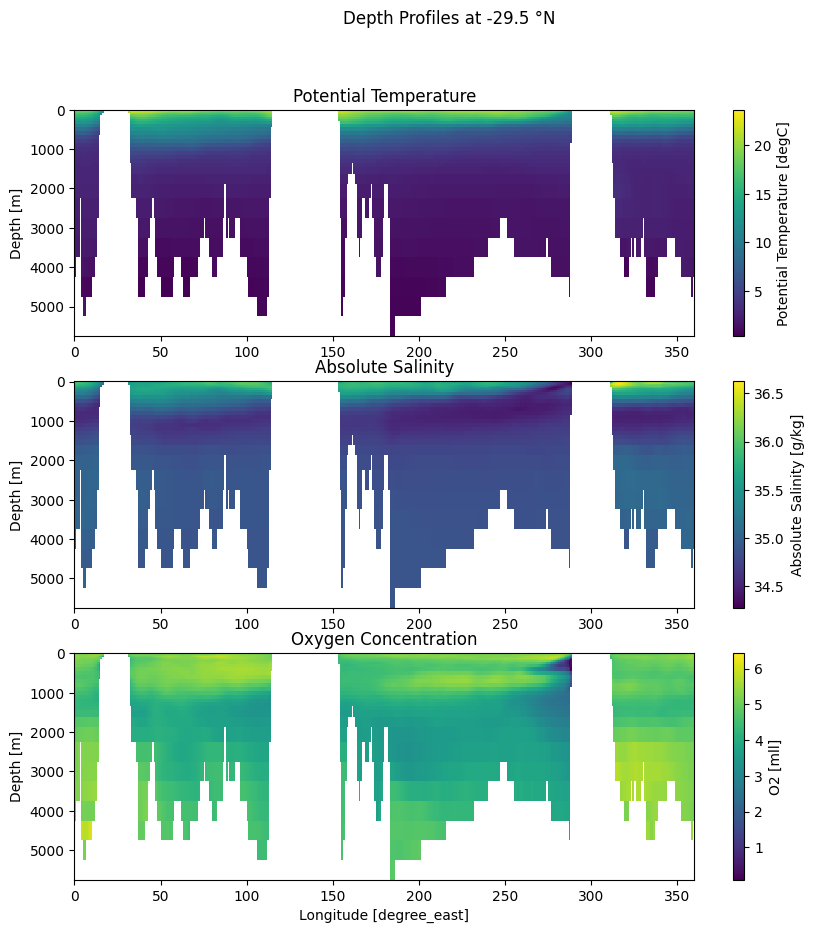

In [26]:
latitude = -29.5
levitus_1a = levitus.sel(lat=latitude, method="nearest")

fig, axs = plt.subplots(nrows=3, figsize=(10,10))
fig.suptitle(f"Depth Profiles at {latitude} °N")

ax_pot_temp = axs[0]
levitus_1a["pot_temp"].plot(x="lon", y="depth", ax=ax_pot_temp)
ax_pot_temp.set_xlabel("")
ax_pot_temp.set_title(f"Potential Temperature")
ax_pot_temp.yaxis.set_inverted(True)

ax_abs_sal = axs[1]
levitus_1a["abs_sal"].plot(x="lon", y="depth", ax=ax_abs_sal)
ax_abs_sal.set_xlabel("")
ax_abs_sal.set_title(f"Absolute Salinity")
ax_abs_sal.yaxis.set_inverted(True)

ax_O2 = axs[2]
levitus_1a["O2"].plot(x="lon", y="depth", ax=ax_O2)
ax_O2.set_title(f"Oxygen Concentration")
ax_O2.yaxis.set_inverted(True)

plt.show()

In [27]:
abs_sal_attrs = attrs=dict(units="g/kg", long_name="Absolute Salinity")

coords=dict(water_mass=["AABW", "UCDW", "NADW"])
UCDW = xr.Dataset(dict(abs_sal=34.3, pot_temp=3.2))
NADW = xr.Dataset(dict(abs_sal=35, pot_temp=3.5))


da_abs_sal = xr.DataArray(
        data=[34.7, 34.3, 35],
        coords=coords, attrs=abs_sal_attrs,
        )
da_pot_temp = xr.DataArray(
        data=[0.3, 3.2, 3.5],
        coords=coords, attrs=abs_sal_attrs,
        )
water_masses = xr.Dataset(
        dict(
                pot_temp=da_pot_temp,
                abs_sal=da_abs_sal,
                )
        )
water_masses["sigma0"] = gsw.density.sigma0(water_masses.abs_sal, water_masses.pot_temp)
water_masses["sigma1"] = gsw.density.sigma1(water_masses.abs_sal, water_masses.pot_temp)


In [28]:
abs_sal = np.linspace(34,36,51)
con_temp = np.linspace(-2,12,51)
sal_temp_grid = np.meshgrid(abs_sal, con_temp)
sigma0 = gsw.density.sigma0(sal_temp_grid[0], sal_temp_grid[1])
sigma1 = gsw.density.sigma1(sal_temp_grid[0], sal_temp_grid[1])
# plt.contour(density)
density = xr.Dataset(
        data_vars=dict(
                sigma0=(["con_temp","abs_sal"], sigma0),
                sigma1=(["con_temp","abs_sal"], sigma1),
                ),
        coords=dict(
                abs_sal=("abs_sal", abs_sal),
                con_temp=("con_temp", con_temp),
        )
)

/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/plot/dataarray_plot.py:2012: UserWarning: The following kwargs were not used by contour: 'linestyle'
  primitive = ax.contour(x, y, z, **kwargs)


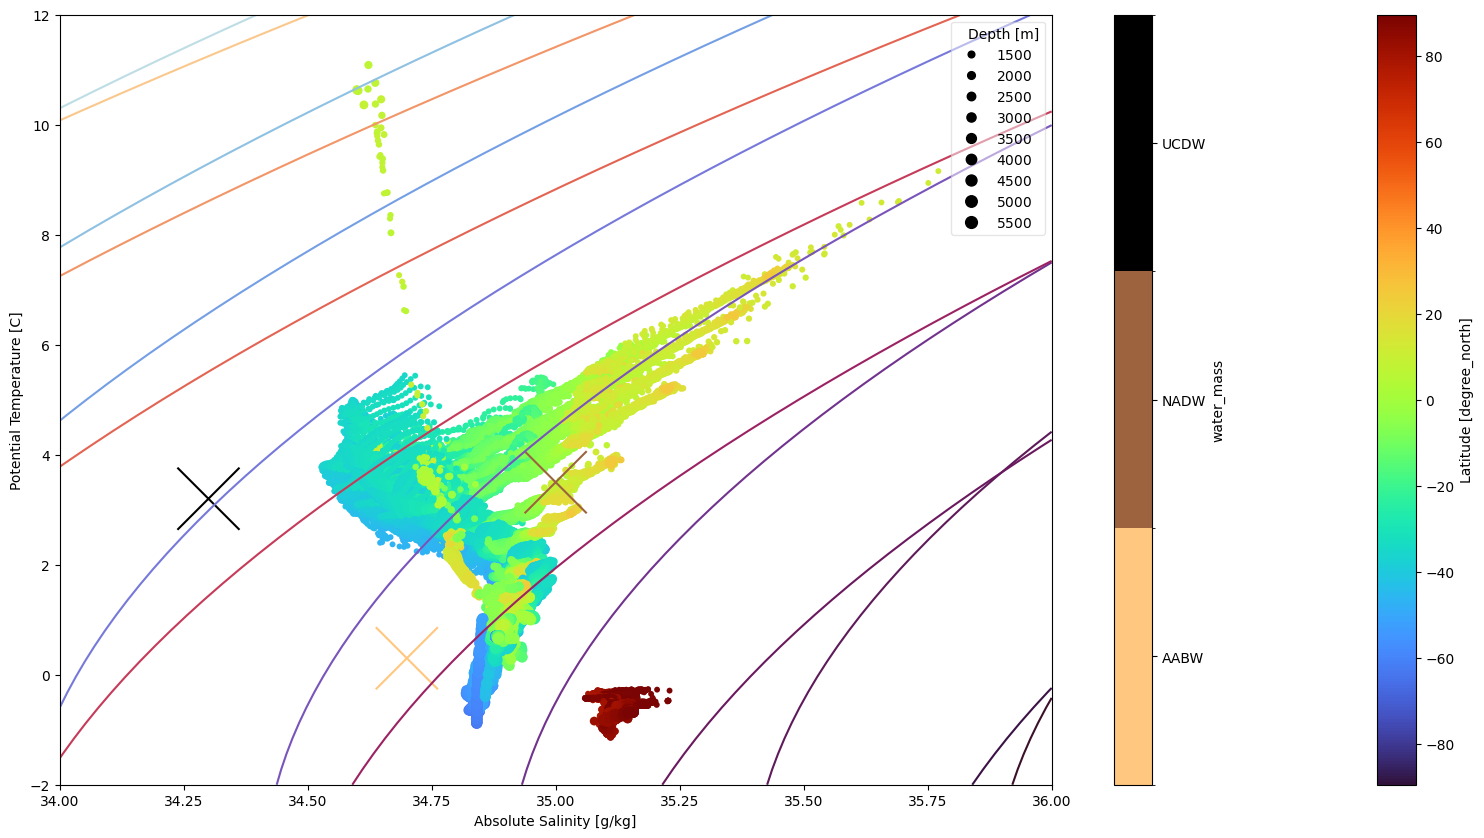

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
ax.set_xlim((34,36))
ax.set_ylim((-2,12))
density.sigma0.plot.contour(ax=ax, cmap=cmocean.cm.dense)
density.sigma1.plot.contour(ax=ax, cmap=cmocean.cm.matter, linestyle="..",)
levitus.sel(lon=slice(30,120), depth=slice(1200,None)).plot.scatter(
        ax=ax,
        x="abs_sal", y="pot_temp", 
        hue="lat", 
        edgecolor="#00000000",
        markersize="depth",
        cmap="turbo",
        )
marker = itertools.cycle((',', '+', '.', 'o', '*'))
markers=['^', 's', 'p', 'h', '8']
water_masses.plot.scatter(
        ax=ax,
        x="abs_sal", y="pot_temp", 
        hue="water_mass",
        s=2000,
        cmap="copper_r",
        marker="x"
        )
ax.set_ylabel("Potential Temperature [C]")
plt.show()

<Figure size 2000x1000 with 0 Axes>

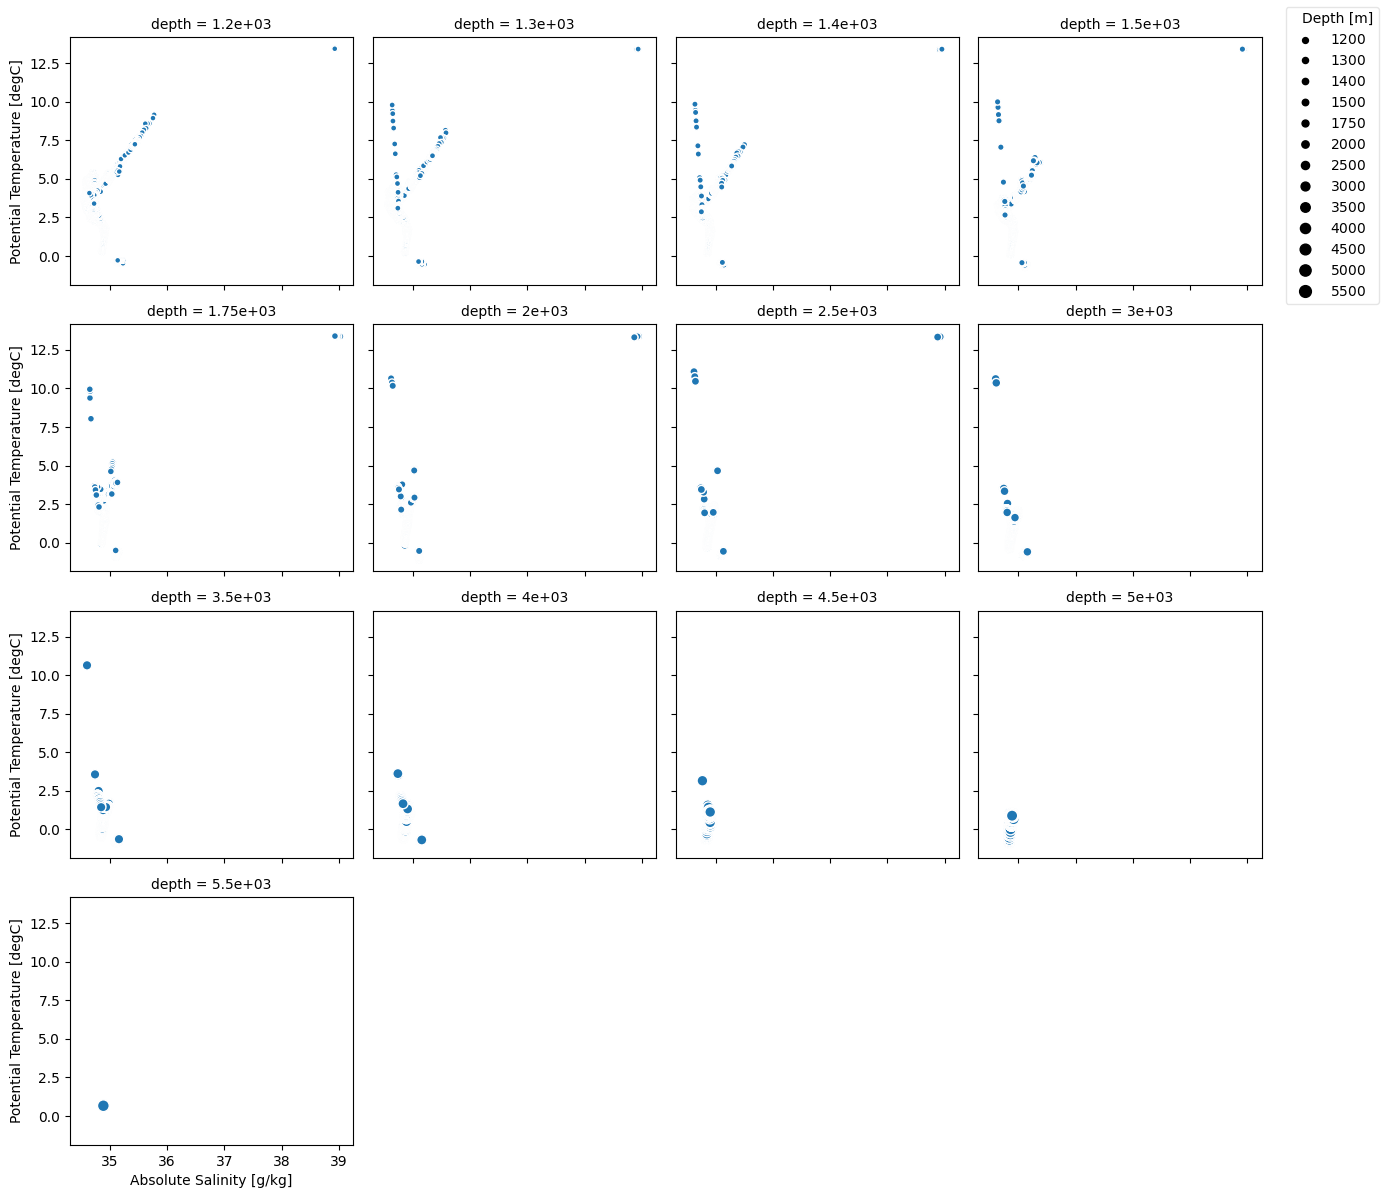

In [30]:
fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(131)
levitus.sel(lon=slice(30,120), depth=slice(1200,None)).plot.scatter(
        x="abs_sal", y="pot_temp", 
        col="depth", col_wrap=4,
        linewidth=0, 
        markersize="depth",
        cmap="coolwarm",
        )
plt.show()

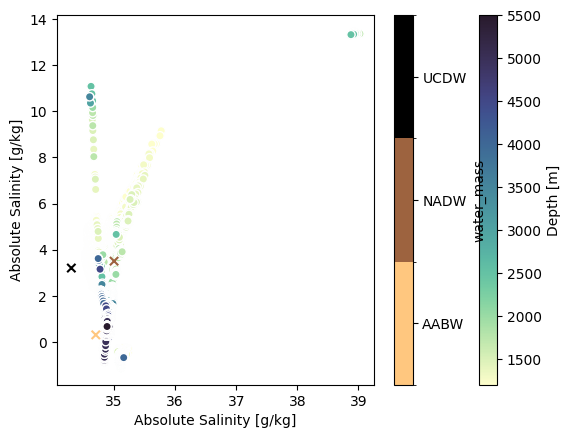

In [31]:
levitus.sel(lon=slice(30,120), depth=slice(1200,None)).plot.scatter(
        x="abs_sal", y="pot_temp", 
        hue="depth", 
        linewidth=0, 
        cmap=cmocean.cm.deep,
        )
# levitus_1a.sel(lon=slice(30,120), depth=slice(1200,None)).plot.scatter(x="abs_sal", y="pot_temp", hue="depth")
water_masses.plot.scatter(x="abs_sal", y="pot_temp", hue="water_mass", marker="x", cmap="copper_r")
# set_ylabel("Potential Temperature [C]")

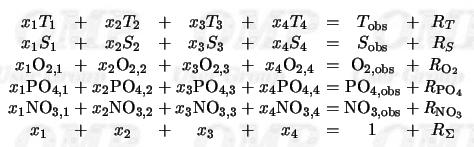

https://omp.geomar.de/node3.html

## System of Equations
x1*t1 + x2*t2 + x3*t3 = T

x1*s1 + x2*s2 + x3*s3 = S

x1 + x2 + x3 = 1

x is fraction, t is temp (T is total temp), s is salinity

1:"AABW", 2:"UCDW", 3:"NADW"



In [32]:
t1=water_masses.pot_temp[0].data
t2=water_masses.pot_temp[1].data
t3=water_masses.pot_temp[2].data

s1=water_masses.abs_sal[0].data
s2=water_masses.abs_sal[1].data
s3=water_masses.abs_sal[2].data

x1 = []  #f_AABW, 
x2 = []  #f_UCDW,
x3 = []  #f_NADW

percentages = [] #f_AABW, f_UCDW, f_NADW

data = levitus_1a.sel(depth=slice(1200, 5500))

array_T = data.pot_temp.data
array_S = data.abs_sal.data

equations = np.array([[t1, t2, t3], [s1, s2, s3], [1, 1, 1]])

sol_array = []

for i in range(len(array_S)):
    sub_array = []
    x1_sub = []
    x2_sub = []
    x3_sub = []
    for j in range(len(array_S[i])):
        solutions = np.array([array_T[i][j], array_S[i][j], 1])
        sol_array.append(solutions)
        # print(solutions)
        # print(solutions[0])
        if not np.isnan(solutions[0]):
        # x_all = scipy.linalg.solve(equations, solutions)
            x_all = scipy.optimize.lsq_linear(equations, solutions, (0, 1))
            percentages.append(x_all)
            sol_array.append(solutions)
            x1_sub.append(x_all.x[0])
            x2_sub.append(x_all.x[1])
            x3_sub.append(x_all.x[2])
        else: # maintain structure of data
            x1_sub.append(np.nan)
            x2_sub.append(np.nan)
            x3_sub.append(np.nan)
    x1.append(x1_sub)
    x2.append(x2_sub)
    x3.append(x3_sub)

data["AABW fraction"] = (data.abs_sal.dims, x1)
data["UCDW fraction"] = (data.abs_sal.dims, x2)
data["NADW fraction"] = (data.abs_sal.dims, x3)


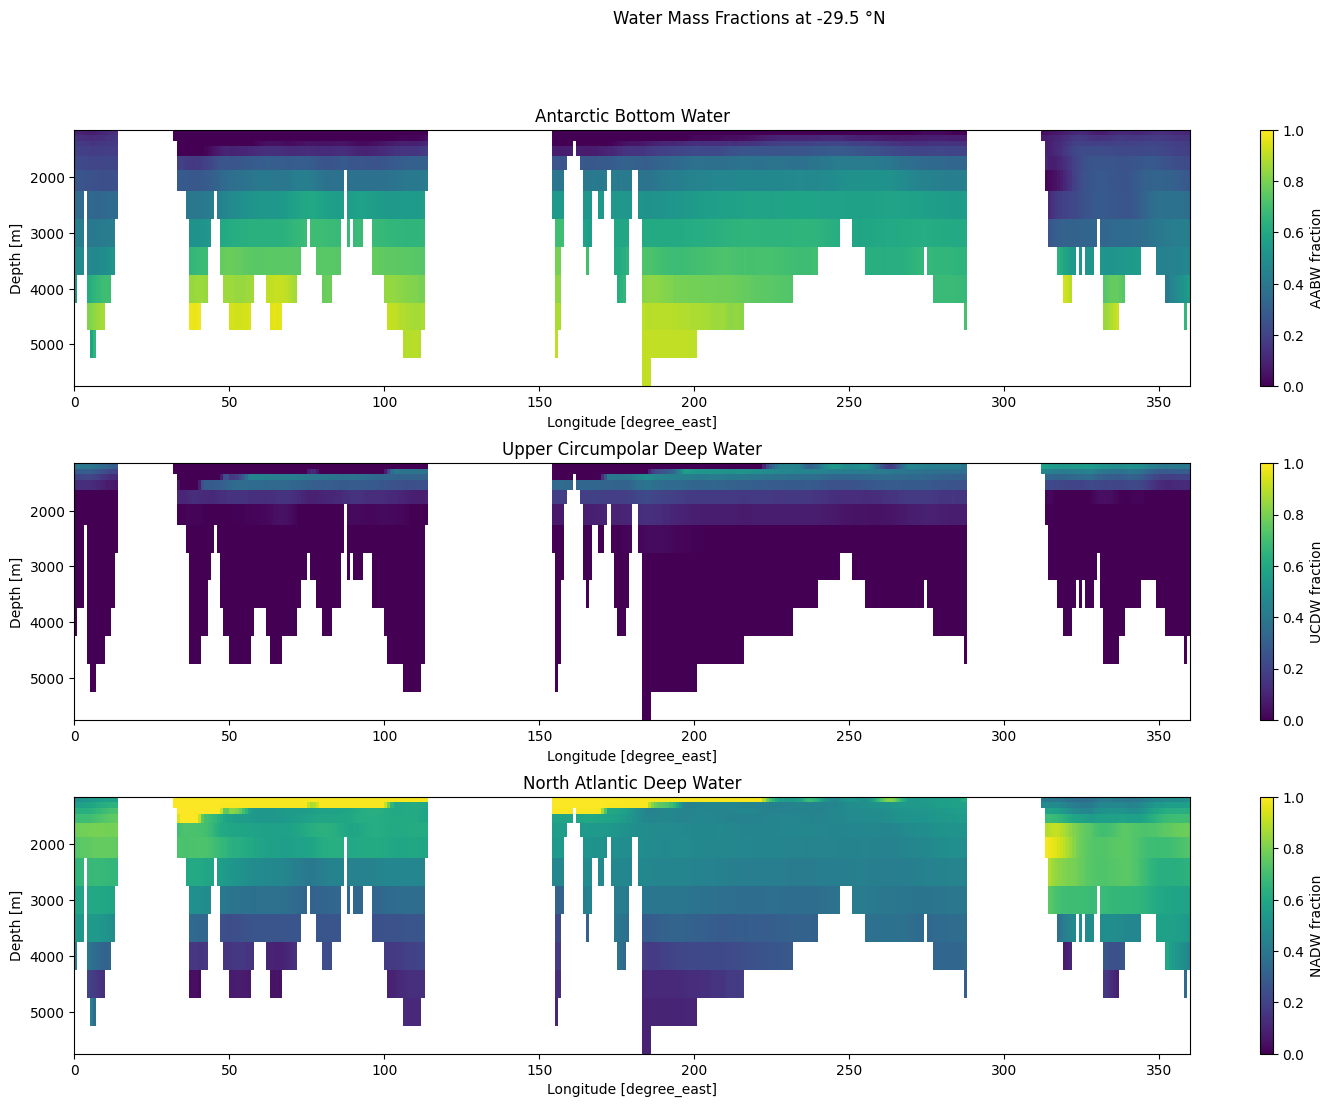

In [33]:
fig, axs = plt.subplots(nrows=3, figsize=(18,12))
fig.suptitle(f"Water Mass Fractions at {latitude} °N")
plt.subplots_adjust(hspace=0.3)

data["AABW fraction"].plot(x="lon", y="depth", ax=axs[0], vmin=0, vmax=1)
axs[0].set_title("Antarctic Bottom Water")
axs[0].yaxis.set_inverted(True)

data["UCDW fraction"].plot(x="lon", y="depth", ax=axs[1], vmin=0, vmax=1)
axs[1].set_title("Upper Circumpolar Deep Water")
axs[1].yaxis.set_inverted(True)

data["NADW fraction"].plot(x="lon", y="depth", ax=axs[2], vmin=0, vmax=1)
axs[2].set_title("North Atlantic Deep Water")
axs[2].yaxis.set_inverted(True)

